In [1]:
import numpy as np
import torch
from torch import nn
import networkx as nx

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Generate Input Data for a Simple Circuit
Circuit is an independent voltage source and a resistor.

MultiGraph with 3 nodes and 3 edges
(0, {'type': 'n', 'v': 0})
(1, {'type': 'n', 'v': ''})
(2, {'type': 'n', 'v': ''})
(0, 1, {'type': 's', 'v': 1, 'i': '', 'p': 1})
(0, 2, {'type': 'r', 'v': 0.5, 'i': '', 'p': ''})
(1, 2, {'type': 'r', 'v': '', 'i': '', 'p': 10})


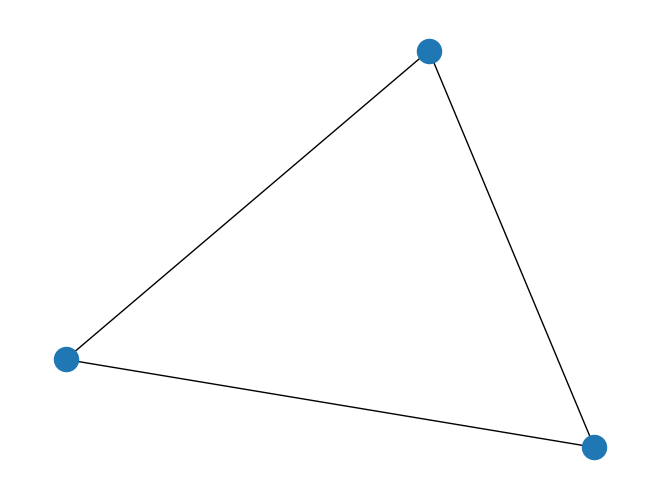

In [3]:
vr = nx.MultiGraph()
vr.add_node(0,type='n',v=0)
vr.add_node(1,type='n',v='')
vr.add_node(2,type='n',v='')
vr.add_edges_from(
        [
            (0,1,{'type':'s','v':1,'i':'','p':1}),
            (2,1,{'type':'r','v':'','i':'','p':10}),
            (2,0,{'type':'r','v':0.5,'i':'','p':''})
        ]
    )
print(vr)
for node in vr.nodes().data():
    print(node)
for edge in vr.edges.data():
    print(edge)
nx.draw(vr)

# Indidence Matrix (KCL loss)

In [4]:
# generate the incidence matrix and convert to numpy array, then pytorch tensor
M_tensor = nx.incidence_matrix(G=vr,oriented=True)
M_tensor = M_tensor.toarray()
print(f'shape of incidence array = {M_tensor.shape}')
print(M_tensor)


shape of incidence array = (3, 3)
[[-1. -1.  0.]
 [ 1.  0. -1.]
 [ 0.  1.  1.]]


C:\Users\terry\AppData\Local\Temp\ipykernel_8368\1758355496.py:2: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_tensor = nx.incidence_matrix(G=vr,oriented=True)


# Expected Sizes of Vectors

In [5]:
# create tensors for voltages, currents, and element params
num_elements = vr.number_of_edges()
num_nodes = vr.number_of_nodes()
print(f'size of element currents, voltages, and params = ({num_elements},1)')
print(f'size of node voltages = ({num_nodes},1)')



size of element currents, voltages, and params = (3,1)
size of node voltages = (3,1)


# Extract Circuit Parameters for the Model

In [6]:
def extract(nx_list: list, params_order_map: dict, types_map: dict):
    '''
    input: node or edge list with data from nx graph. Key order is a list of maps 
    from the parameter key to the desired order in the ouput vectors [{str:int}]

    output:  two matrices. 
                params matrix rows are each edge/node of graph.  Columns are
                    each param value corresponding to key order
                knowns matrix rows are each edge/node of graph.  Columns are 
                    boolean of if the param value is known
    '''
    param_matrix = []
    knowns_matrix = []
    type_matrix = []
    num_params = len(next(iter(nx_list))[-1])-1
    num_types = len(types_map)
    print(f'len(key_order_map) = num_params => {len(params_order_map)}, {num_params}' )
    assert(len(params_order_map) == num_params)
    for item in nx_list: # each edge or node
        last_element: dict = item[-1]
        type_oh = [0]*(num_types) # one-hot encoding
        values = [0]*(num_params)
        knowns_oh = [0]*(num_params) # one-hot encoding
        for parameter,value in last_element.items():
            if(parameter == 'type'):
                type_idx = types_map[value]
                type_oh[type_idx] = 1
                continue
            
            idx = params_order_map[parameter]
            if(value==''):
                values[idx] = 0.0
                knowns_oh[idx] = 0
            else:
                values[idx] = float(value)
                knowns_oh[idx] = 1
        param_matrix.append(values)
        knowns_matrix.append(knowns_oh)
        type_matrix.append(type_oh)

    param_matrix = np.array(param_matrix)
    knowns_matrix = np.array(knowns_matrix)
    type_matrix = np.array(type_matrix)
        
    return (type_matrix, param_matrix, knowns_matrix)


In [7]:

node_map = {'v':0}
types_map = {'n':0,'s':1, 'r':2}
node_types, node_params, node_knowns = extract(vr.nodes().data(), node_map, types_map)
node_types, node_params, node_knowns

len(key_order_map) = num_params => 1, 1


(array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]),
 array([[0.],
        [0.],
        [0.]]),
 array([[1],
        [0],
        [0]]))

In [8]:
edge_map = {'v':0, 'i':1, 'p':2}
element_types, element_params, element_knowns = extract(vr.edges.data(), edge_map, types_map)
element_types, element_params, element_knowns

len(key_order_map) = num_params => 3, 3


(array([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]]),
 array([[ 1. ,  0. ,  1. ],
        [ 0.5,  0. ,  0. ],
        [ 0. ,  0. , 10. ]]),
 array([[1, 0, 1],
        [1, 0, 0],
        [0, 0, 1]]))

# Convert Input Data to Tensors

In [9]:
pot_vector = node_params[:,0].reshape(num_nodes,1)
v_vector = element_params[:,edge_map['v']].reshape(num_elements,1)
i_vector = element_params[:,edge_map['i']].reshape(num_elements,1)
param_vector = element_params[:,edge_map['p']].reshape(num_elements,1)

In [10]:
pot_tensor = torch.tensor(pot_vector,requires_grad=False,dtype=torch.double,device=device)
v_tensor = torch.tensor(v_vector,requires_grad=False,dtype=torch.double,device=device)
i_tensor = torch.tensor(i_vector,requires_grad=False,dtype=torch.double,device=device)
param_tensor = torch.tensor(param_vector,requires_grad=False,dtype=torch.double,device=device)
pot_tensor,v_tensor,i_tensor,param_tensor

(tensor([[0.],
         [0.],
         [0.]], device='cuda:0', dtype=torch.float64),
 tensor([[1.0000],
         [0.5000],
         [0.0000]], device='cuda:0', dtype=torch.float64),
 tensor([[0.],
         [0.],
         [0.]], device='cuda:0', dtype=torch.float64),
 tensor([[ 1.],
         [ 0.],
         [10.]], device='cuda:0', dtype=torch.float64))

# Masks

In [11]:
# knowns masks
pot_mask = node_knowns
v_mask = element_knowns[:,edge_map['v']].reshape(num_elements,1)
i_mask = element_knowns[:,edge_map['i']].reshape(num_elements,1)
param_mask = element_knowns[:,edge_map['p']].reshape(num_elements,1)

pot_mask = torch.tensor(pot_mask,dtype=bool, requires_grad=False,device=device)
v_mask = torch.tensor(v_mask,dtype=bool,requires_grad=False,device=device)
i_mask = torch.tensor(i_mask,dtype=bool,requires_grad=False,device=device)
param_mask = torch.tensor(param_mask,dtype=bool,requires_grad=False,device=device)

pot_mask, v_mask, i_mask, param_mask

(tensor([[ True],
         [False],
         [False]], device='cuda:0'),
 tensor([[ True],
         [ True],
         [False]], device='cuda:0'),
 tensor([[False],
         [False],
         [False]], device='cuda:0'),
 tensor([[ True],
         [False],
         [ True]], device='cuda:0'))

In [12]:
# inverted knowns masks
pot_mask_inv = ~pot_mask
v_mask_inv = ~v_mask
i_mask_inv = ~i_mask
param_mask_inv = ~param_mask

pot_mask_inv, v_mask_inv, i_mask_inv, param_mask_inv

(tensor([[False],
         [ True],
         [ True]], device='cuda:0'),
 tensor([[False],
         [False],
         [ True]], device='cuda:0'),
 tensor([[True],
         [True],
         [True]], device='cuda:0'),
 tensor([[False],
         [ True],
         [False]], device='cuda:0'))

In [13]:
param_tensor[param_mask_inv]

tensor([0.], device='cuda:0', dtype=torch.float64)

In [14]:
# resistor device equation
resistor_mask = torch.tensor(element_types[:,types_map['r']],requires_grad=False,dtype=torch.double,device=device)
resistor_mask = resistor_mask.reshape(num_elements,1)
resistor_mask

tensor([[0.],
        [1.],
        [1.]], device='cuda:0', dtype=torch.float64)

In [15]:
# source device equation
source_mask = torch.tensor(element_types[:,types_map['s']],requires_grad=False,dtype=torch.double,device=device)
source_mask = source_mask.reshape(num_elements,1)
source_mask

tensor([[1.],
        [0.],
        [0.]], device='cuda:0', dtype=torch.float64)

In [16]:
resistor_func = i_tensor * param_tensor - v_tensor
resistor_func

tensor([[-1.0000],
        [-0.5000],
        [ 0.0000]], device='cuda:0', dtype=torch.float64)

In [17]:
masked_resistor = resistor_func * resistor_mask
masked_resistor

tensor([[-0.0000],
        [-0.5000],
        [ 0.0000]], device='cuda:0', dtype=torch.float64)

In [18]:
i_tensor * param_tensor - v_tensor

tensor([[-1.0000],
        [-0.5000],
        [ 0.0000]], device='cuda:0', dtype=torch.float64)

# Circuit Theory Functions

In [19]:
M_tensor = torch.tensor(M_tensor,requires_grad=True,dtype=torch.double,device=device)
M_tensor

tensor([[-1., -1.,  0.],
        [ 1.,  0., -1.],
        [ 0.,  1.,  1.]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)

# Models

In [20]:
class KCL(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, M_tensor, i_tensor):
        return M_tensor @ i_tensor

In [21]:
class KVL(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, M_tensor, v_tensor, pot_tensor):
        return M_tensor.T @ pot_tensor - v_tensor

In [22]:
class Resistor(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, i_tensor, v_tensor, param_tensor, resistor_mask):
        # zero out non-resistors
        resistor_func = i_tensor * param_tensor - v_tensor
        masked_resistor = resistor_func * resistor_mask
        return masked_resistor

In [23]:
class Source(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, v_tensor, param_tensor, source_mask):
        # zero out non-sources
        source_func = v_tensor - param_tensor
        masked_resistor = resistor_func * source_mask
        return masked_resistor

In [24]:
# Define model
class Solver(nn.Module):
    def __init__(self):
        super().__init__()
        # inputs with randomized unknowns
        self.M = M_tensor # no unknowns
        self.pot = nn.Parameter(pot_tensor + torch.rand_like(pot_tensor) * pot_mask_inv)
        self.v = nn.Parameter(v_tensor + torch.rand_like(v_tensor) * v_mask_inv)
        self.i = nn.Parameter(i_tensor + torch.rand_like(i_tensor) * i_mask_inv)
        self.param = nn.Parameter(param_tensor + torch.rand_like(param_tensor) * param_mask_inv)

        # declare custom layers
        self.kcl = KCL()
        self.kvl = KVL()
        self.resistor = Resistor()
        self.source = Source()

    def forward(self): # no "x" or other inputs because no inference mode
        resistor_out = self.resistor(self.i, self.v, self.param,
                                         resistor_mask) # @TODO replace with dyanamic element function
        source_out = self.source(self.v, self.param, source_mask)
        kvl_out = self.kvl(self.M, self.v, self.pot)
        kcl_out = self.kcl(self.M, self.i)

        return torch.cat(tensors=(kcl_out, resistor_out, kvl_out, source_out))

model = Solver().to(device)
print(model)

Solver(
  (kcl): KCL()
  (kvl): KVL()
  (resistor): Resistor()
  (source): Source()
)


# Loss

In [25]:
loss_fn = nn.MSELoss()

# Optimizer

In [26]:
# select the unknowns for optimization
pot_opt = model.pot[pot_mask_inv]
v_opt = model.v[v_mask_inv]
i_opt = model.i[i_mask_inv]
param_opt = model.param[param_mask_inv]
opt_params_cat = torch.cat((pot_opt,v_opt,i_opt,param_opt))
pot_opt,v_opt,i_opt,param_opt,opt_params_cat

(tensor([0.3651, 0.1543], device='cuda:0', dtype=torch.float64,
        grad_fn=<IndexBackward0>),
 tensor([0.4989], device='cuda:0', dtype=torch.float64,
        grad_fn=<IndexBackward0>),
 tensor([0.0387, 0.9559, 0.9532], device='cuda:0', dtype=torch.float64,
        grad_fn=<IndexBackward0>),
 tensor([0.3059], device='cuda:0', dtype=torch.float64,
        grad_fn=<IndexBackward0>),
 tensor([0.3651, 0.1543, 0.4989, 0.0387, 0.9559, 0.9532, 0.3059],
        device='cuda:0', dtype=torch.float64, grad_fn=<CatBackward0>))

In [27]:
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.01)

# Train Function

In [ ]:
def get_errors():
    pass

In [ ]:
def apply_errors():
    
    pass

In [28]:
def train(model, loss_fn, optimizer):
    model.train()
    
    # Compute prediction error
    pred = model() # model takes no inputs
    loss = loss_fn(pred, torch.zeros_like(pred))

    # zero out the cached set of gradients
    optimizer.zero_grad()

    # Backpropagation to produce gradients
    loss.backward()

    # zero out the gradients for knowns before stepping optimizer
    model.pot.grad[pot_mask] = 0
    model.v.grad[v_mask] = 0
    model.i.grad[i_mask] = 0
    model.param.grad[param_mask] = 0

    # update the model parameters with gradients
    optimizer.step()

    # adjusting parameters with heuristics
    with torch.no_grad():
        # clipping parameters (e.g. resistance greater than zero)
        torch.nn.functional.relu(model.param, inplace=True)
        # perform correction (calculate errors, diffuse and update)

    return loss

# Test Function 

No inference therefore no testing!

# Run Train Loop

In [29]:
epochs = 10000

loss = 0
prev_loss = 0.1

for t in range(epochs):
    loss = train(model, loss_fn, optimizer)
    loss_change = abs(loss - prev_loss) / prev_loss

    prev_loss = loss

    if t % 1000 == 0:
        print(f'epoch {t} loss = {loss} ({loss_change} per unit change)')

    if loss_change < 0.00000000001:
        print(f'finished early for loss threshold with {t} epochs')
        break

print("Done!")
print(f'potentials = {model.pot}')
print(f'voltages = {model.v}')
print(f'currents = {model.i}')
print(f'parameters = {model.param}')

epoch 0 loss = 7.427595231751924 (73.27595231751924 per unit change)
epoch 1000 loss = 0.08751732393875289 (0.00024226360357883196 per unit change)
epoch 2000 loss = 0.08359953079107316 (2.20897627112182e-06 per unit change)
epoch 3000 loss = 0.08347222223027106 (1.0721886185578871e-06 per unit change)
epoch 4000 loss = 0.08340552423254952 (5.811375188700318e-07 per unit change)
epoch 5000 loss = 0.08336911373781597 (3.1790872047257486e-07 per unit change)
epoch 6000 loss = 0.08334948778643932 (1.6821245033276604e-07 per unit change)
epoch 7000 loss = 0.083339607554477 (7.942757593104007e-08 per unit change)
epoch 8000 loss = 0.08333527993122032 (3.171046109452233e-08 per unit change)
epoch 9000 loss = 0.08333376543671696 (9.656627958613554e-09 per unit change)
Done!
potentials = Parameter containing:
tensor([[0.0000],
        [1.0016],
        [0.4994]], device='cuda:0', dtype=torch.float64, requires_grad=True)
voltages = Parameter containing:
tensor([[ 1.0000],
        [ 0.5000],
   